### Adding Import Statements

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In /Users/azadesanjari/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/azadesanjari/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/azadesanjari/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/azadesanjari/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/azadesanjari/anaconda3

In [2]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
ses = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
ses.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
ses['user_id'].drop_duplicates().shape

(8823,)

### Data Wrangling

In [5]:
ses['time_stamp'] = pd.to_datetime(ses['time_stamp']) - pd.to_timedelta(7, unit='d')

In [6]:
ses_stats = pd.Series([])

/Users/azadesanjari/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [7]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = ses.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()

In [8]:
ses_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

In [9]:
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)

In [10]:
df['adopted_user'].value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

In [11]:
invited_users = df[df['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
invited_users = pd.Series(1, index=invited_users)

### Exploratory Data analysis

<AxesSubplot:xlabel='creation_source', ylabel='count'>

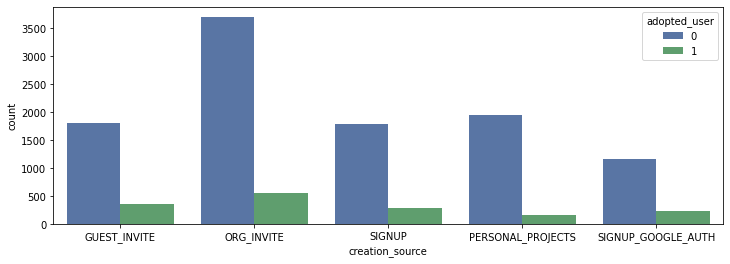

In [14]:
plt.figure(figsize=(12,4))
sns.countplot(x='creation_source', data=df, hue='adopted_user', palette='deep')

### Feature Selection 

In [15]:
df = df.set_index('object_id')

In [16]:
df = df.drop('name', axis=1)

In [17]:
df['email'].value_counts().head(10)

JaninaSankt@gmail.com         2
TomSchiffer@gmail.com         2
LaerkeMBertelsen@gmail.com    2
KerstinNeudorf@gmail.com      2
KristinKappel@yahoo.com       2
ThomasBrandt@gmail.com        2
LasseLNrgaard@gmail.com       2
MandySchroder@gustr.com       2
NicolaiSHolm@yahoo.com        2
LeonieDuerr@gmail.com         2
Name: email, dtype: int64

In [18]:
df = df.drop('invited_by_user_id', axis=1)

In [19]:
df['org_id'].value_counts().shape

(417,)

In [20]:
df[df['adopted_user'] == 1]['org_id'].value_counts().shape

(400,)

In [21]:
df = df.drop('org_id', axis=1)

In [22]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [23]:
df = df.drop('creation_time', axis=1)

In [24]:
df['year'] = df['year'].astype('str')
df['month'] = df['month'].astype('str')

In [25]:
df = pd.get_dummies(df, prefix='is')

In [26]:
#df = df.drop('last_session_creation_time', axis=1)
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())

### Predictive Analytics

In [27]:
X, y = df.drop('adopted_user', axis=1), df['adopted_user']

In [28]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

In [29]:
classifier = GradientBoostingClassifier(verbose=True)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           0.6591            2.29m
         2           0.5913            2.25m
         3           0.5421            2.38m
         4           0.5044            2.30m
         5           0.4748            2.24m
         6           0.4507            2.27m
         7           0.4305            2.24m
         8           0.4132            2.27m
         9           0.3982            2.27m
        10           0.3833            2.26m
        20           0.3020            2.04m
        30           0.2678            1.75m
        40           0.2481            1.42m
        50           0.2363            1.09m
        60           0.2246           49.17s
        70           0.2134           35.29s
        80           0.2019           22.62s
        90           0.1909           10.95s
       100           0.1812            0.00s


0.9577777777777777

In [30]:
confusion_matrix(test_y, classifier.predict(test_X))

array([[1551,    9],
       [  67,  173]])

In [31]:
classifier.feature_importances_.shape

(12003,)

In [32]:
features = pd.Series(classifier.feature_importances_, index=X.columns)

In [ ]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_, palette='deep')

<AxesSubplot:>